### Прогнозирование нагрузки на сервер 

Метрика **`views` (просмотры)** была выбрана в качестве ключевого индикатора нагрузки.

В ходе анализа исторических данных был выявлен период **флешмоба, проведенного с 05.12.2025 по 11.12.2025**. Этот период показал значительный и статистически значимый рост метрики `views`.

Так как `DAU` является опережающим или сопутствующим индикатором активности пользователей, в качестве регрессора возьмем: `DAU` и будем учитывать период флешмоба как аномалию в данных.

In [ ]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

#подключение к бд
from dotenv import load_dotenv
import os
import clickhouse_connect

import warnings
import logging

# Отключаем ворнинги matplotlib
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)

In [62]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components 

In [ ]:
load_dotenv()

connection = clickhouse_connect.get_client(
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    username=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_DATABASE")
)

In [64]:
query="""
SELECT 
    toDate(time) AS day,
    countIf(action = 'view') AS views,
    count(distinct user_id) AS DAU
FROM simulator_20251220.feed_actions
GROUP BY day
ORDER BY day
"""

In [65]:
df=ph.read_clickhouse(query, connection=connection)
df.head()

,day,views,DAU
0,2025-10-25,7603,878
1,2025-10-26,62770,2238
2,2025-10-27,105526,3105
3,2025-10-28,118996,3721
4,2025-10-29,174454,4617


In [66]:
#Добавим столбец, отмечающий даты проведения флешмоба как аномалию
df['anomaly']=np.where((df['day']>= '2025-12-05') & (df['day'] <= '2025-12-11'), 1,0)


In [67]:
#отберем 2 последние недели в качестве тестовых данных (для проверки модели)
cutoff_day=pd.Timestamp.now().normalize() - pd.Timedelta (days=14)
df_test=df.loc[df.day>= cutoff_day].copy()
df_train=df.loc[df.day < cutoff_day].copy()   
df_test.tail()

,day,views,DAU,anomaly
81,2026-01-14,785880,18673,0
82,2026-01-15,722608,18594,0
83,2026-01-16,704717,18300,0
84,2026-01-17,749646,18729,0
85,2026-01-18,288237,12217,0


In [68]:
df_train.tail()

,day,views,DAU,anomaly
66,2025-12-30,719064,19363,0
67,2025-12-31,727028,19466,0
68,2026-01-01,648856,18995,0
69,2026-01-02,720009,18646,0
70,2026-01-03,617308,18755,0


In [98]:
#Для первичного построения модели лучше стандартизировать данные (привести dau и views к z-score)
views_mean=df_train.views.mean()
views_stad=df_train.views.std()

df_train['views_std']=(df_train.views-views_mean)/views_std

dau_mean=df_train.DAU.mean()
dau_stad=df_train.DAU.std()

df_train['dau_std']=(df_train.DAU-dau_mean)/dau_std
df_train.head()

,day,views,DAU,anomaly,views_std,dau_std
0,2025-10-25,7603,878,0,-1.985171,-2.530440
1,2025-10-26,62770,2238,0,-1.774650,-2.261828
2,2025-10-27,105526,3105,0,-1.611490,-2.090587
3,2025-10-28,118996,3721,0,-1.560087,-1.968922
4,2025-10-29,174454,4617,0,-1.348455,-1.791953


In [71]:
sns.set(rc={'figure.figsize':(25,6)}, style="whitegrid")

Text(0.5, 1.0, 'Тренд просмотров (views) в обучающей выборке')

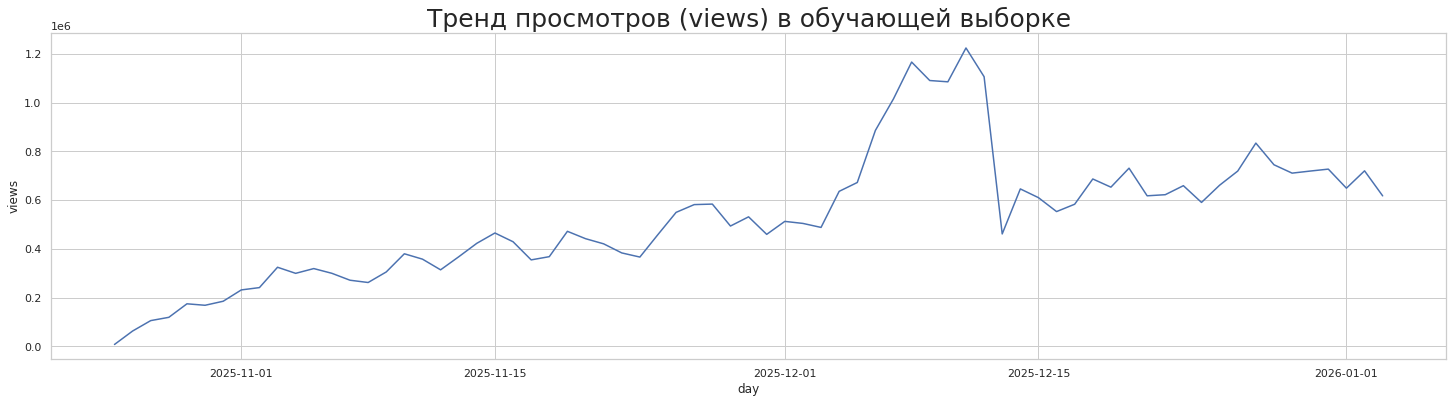

In [142]:
sns.lineplot(x="day", y="views", data=df_train)
plt.title("Тренд просмотров (views) в обучающей выборке", fontsize=25)


Text(0.5, 1.0, 'Тренд DAU в обучающей выборке')

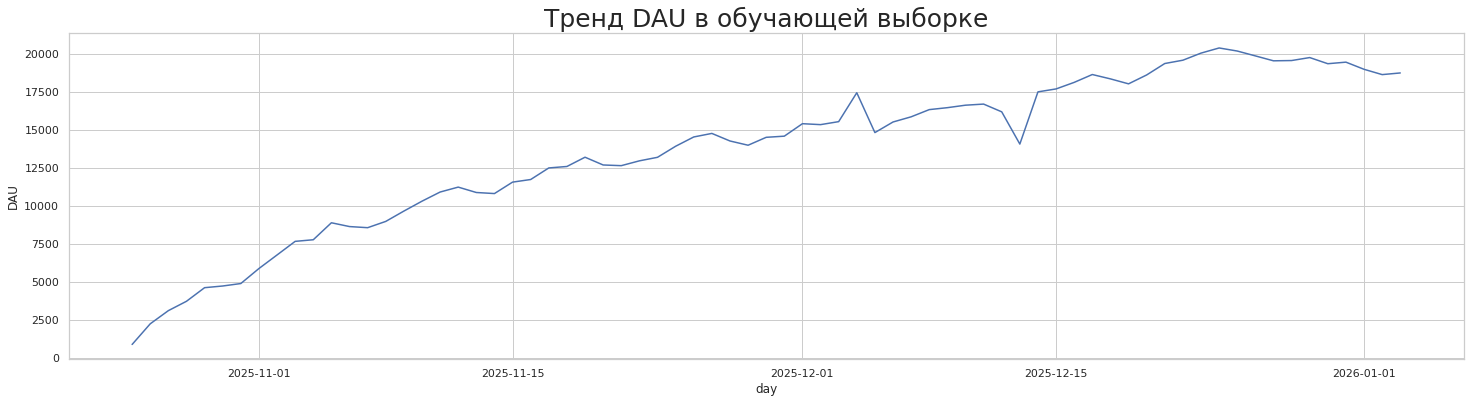

In [143]:
sns.lineplot(x="day", y='DAU', data=df_train)
plt.title('Тренд DAU в обучающей выборке', fontsize=25)

### Прогнозные модели

    1. Модель DLT на основе Markov-Chain Monte Carlo (MCMC)
    2. Модель DLT на основе Maximum a Posteriori
    3. Модель DLT МСMC + регрессоры DAU и аномальный период (период флешмоба)
    4. Модель DLT MAP + регрессоры DAU и аномальный период (период флешмоба)

In [144]:
dlt_1 = DLT(response_col="views_std", 
                 date_col="day", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000) 

dlt_2 = DLT(response_col="views_std", #название колонки с метрикой
            date_col="day", #название колонки с датами-временем
            estimator="stan-map", #алгоритм оценки
            n_bootstrap_draws=1000) 
dlt_3 = DLT(response_col="views_std", 
            date_col="day", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["dau_std", "anomaly"], regressor_sign=["+", "+"], 
            num_warmup=10000,
            num_sample=10000)
dlt_4= DLT(response_col="views_std", #название колонки с метрикой
            date_col="day", #название колонки с датами-временем
            estimator="stan-map", #алгоритм оценки
            regressor_col=["dau_std", "anomaly"], regressor_sign=["+", "+"],
            n_bootstrap_draws=1000) 

2026-01-18 10:40:44 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2026-01-18 10:40:44 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [75]:
model_list = [dlt_1, dlt_2, dlt_3, dlt_4]

In [76]:
for model in model_list:
    model.fit(df_train)

2026-01-18 09:37:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:38:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [79]:
future_df = model_list[0].make_future_df(periods=30) #горизонт будет 30 дней 
predicted_1= model_list[0].predict(future_df)
predicted_2= model_list[1].predict(future_df)

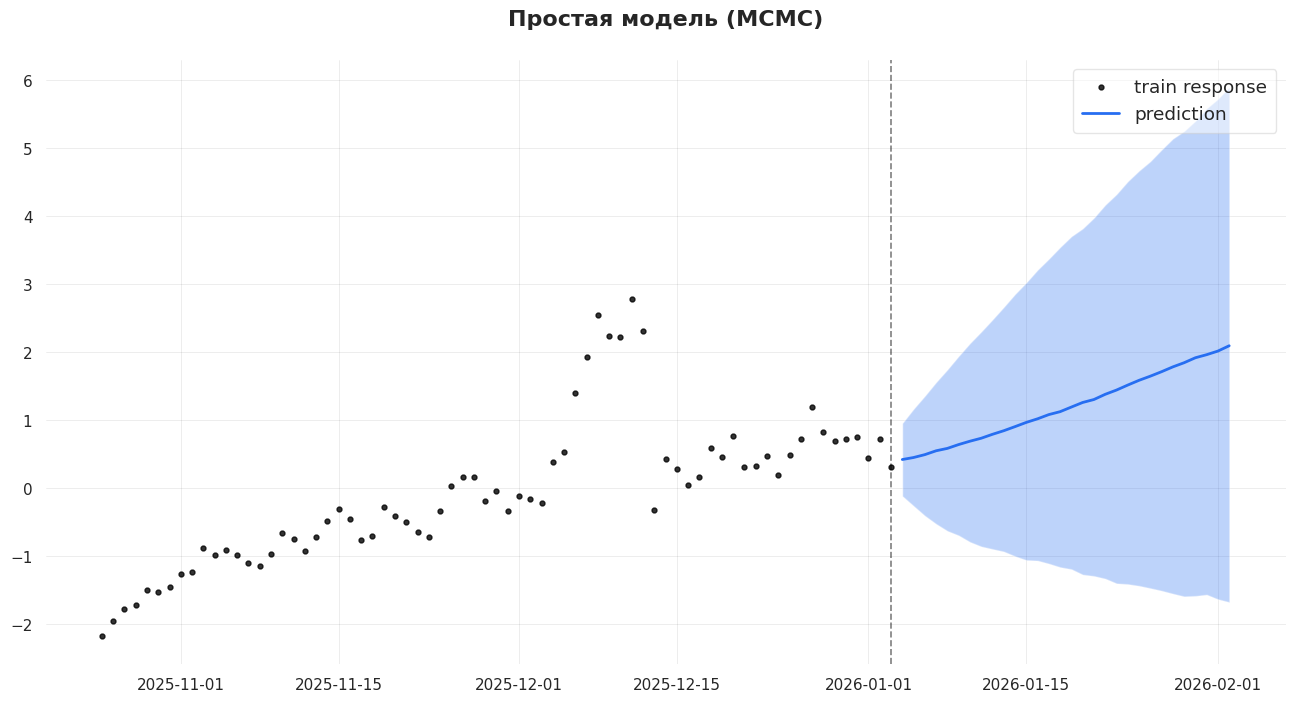

In [80]:
_ = plot_predicted_data(df_train, predicted_1, "day", 'views_std', title='Простая модель (MCMC)')

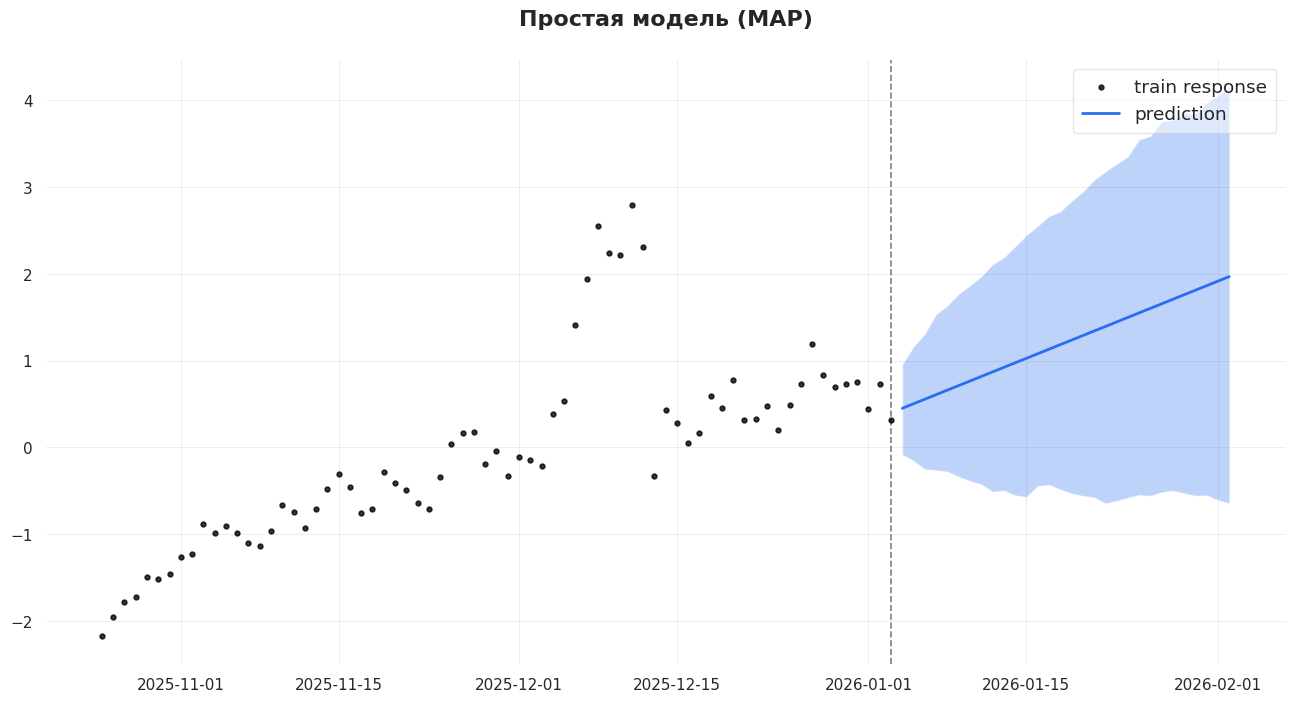

In [81]:
_ = plot_predicted_data(df_train, predicted_2, "day", 'views_std', title='Простая модель (MAP)')

In [82]:
#прогнозируем DAU, для моделей с регрессором
dau_model = DLT(response_col="dau_std", 
                 date_col="day", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

dau_model.fit(df_train)
dau_pred = dau_model.predict(future_df)

2026-01-18 09:38:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

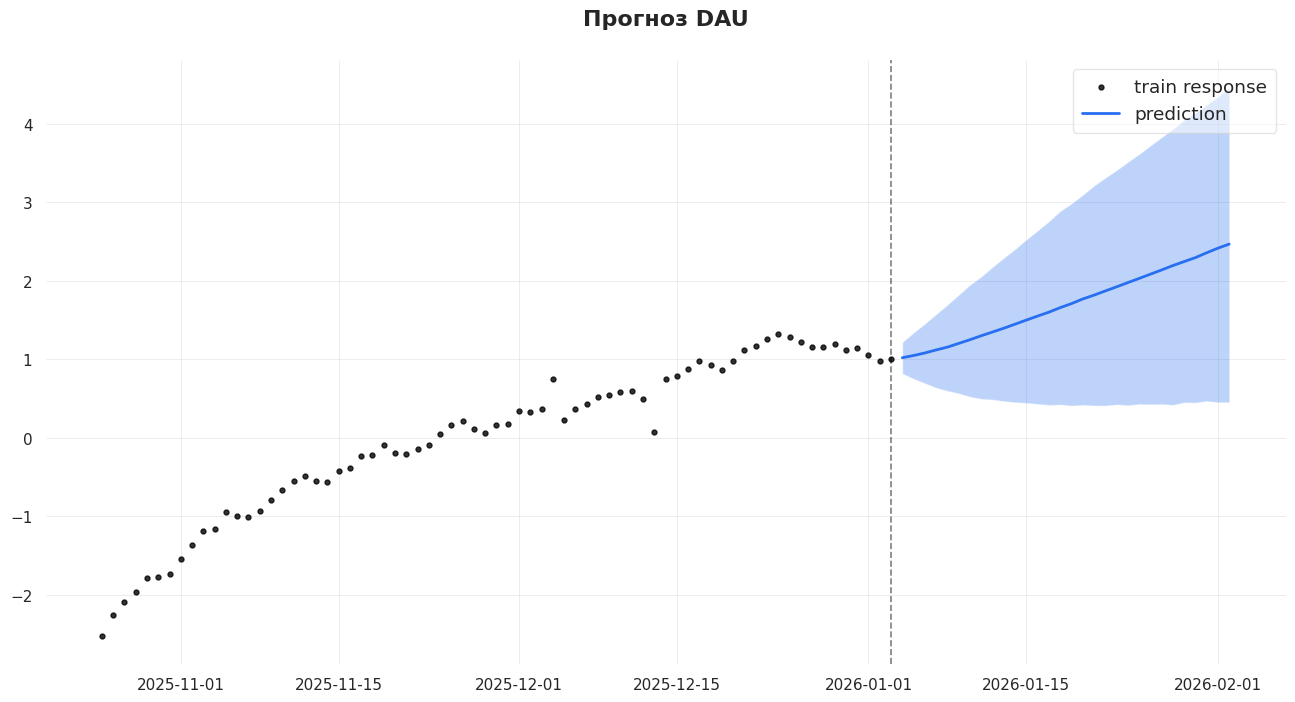

In [83]:
_ = plot_predicted_data(df_train, dau_pred, "day", 'dau_std', title='Прогноз DAU')

In [103]:
dau_pred.head()

,day,prediction_5,prediction,prediction_95
0,2026-01-04,0.817495,1.019228,1.219032
1,2026-01-05,0.750306,1.047569,1.340591
2,2026-01-06,0.693247,1.079892,1.454361
3,2026-01-07,0.637168,1.118592,1.574795
4,2026-01-08,0.597135,1.154187,1.695444


In [117]:
future_df["dau_std"] = dau_pred.prediction
future_df["anomaly"] = 0

In [118]:
predicted_3= model_list[2].predict(future_df)
predicted_4= model_list[3].predict(future_df)

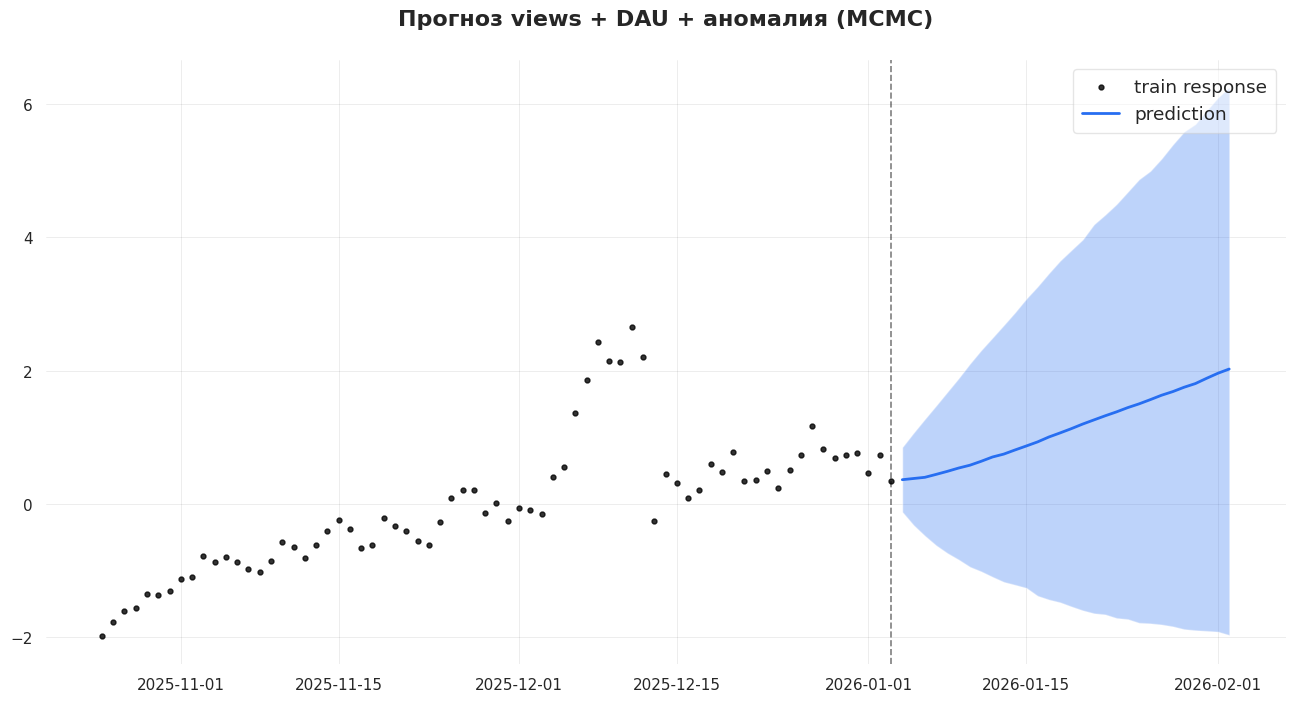

In [119]:
_ = plot_predicted_data(df_train, predicted_3, "day", 'views_std', title='Прогноз views + DAU + аномалия (MCMC)')

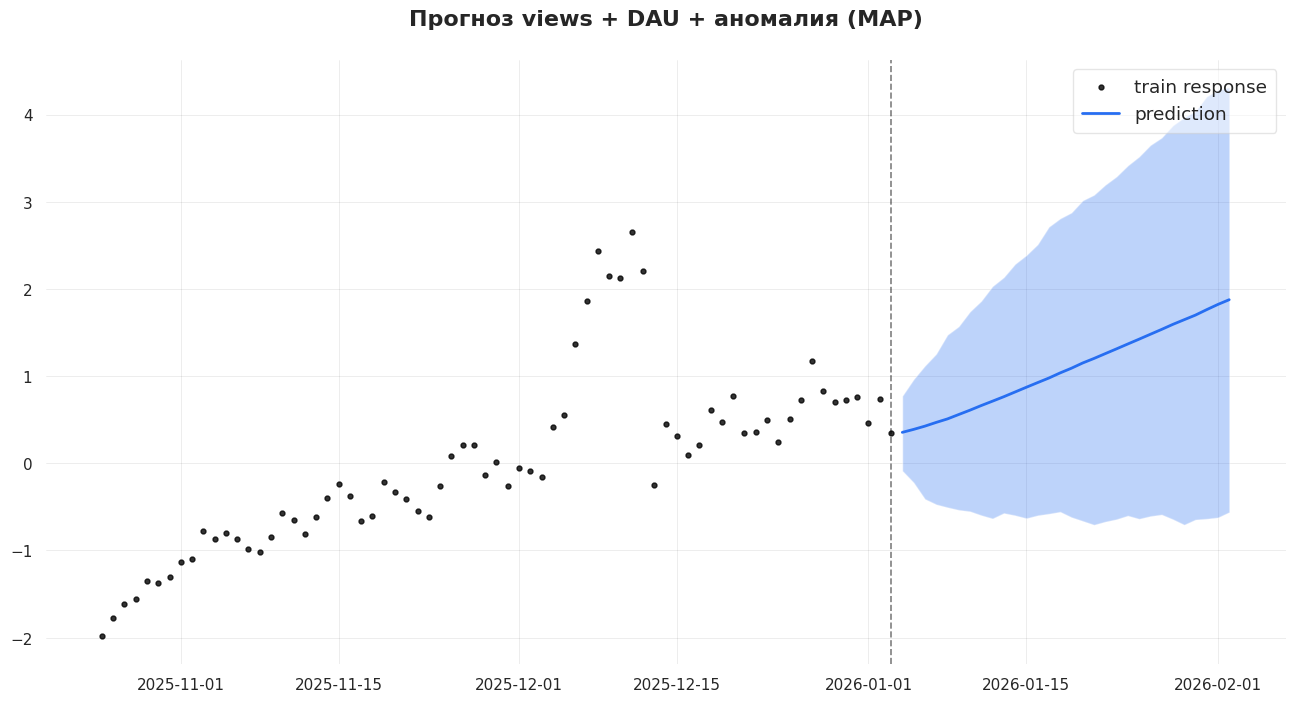

In [120]:
_ = plot_predicted_data(df_train, predicted_4, "day", 'views_std', title='Прогноз views + DAU + аномалия (MAP)')

In [121]:
predicted_1.head()

,day,prediction_5,prediction,prediction_95
0,2026-01-04,-0.114227,0.422363,0.956702
1,2026-01-05,-0.259824,0.452000,1.166982
2,2026-01-06,-0.404207,0.494270,1.358451
3,2026-01-07,-0.524308,0.550959,1.560271
4,2026-01-08,-0.627424,0.586210,1.745934


In [122]:
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров

In [123]:
#rolling

test_list_rolling = []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=df_train,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="rolling")
    
    backtester.fit_predict()
    
    test_list_rolling.append(backtester)

2026-01-18 09:58:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:58:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:58:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:58:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:58:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-18 09:59:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [126]:
print(test_list_rolling)

[<orbit.diagnostics.backtest.BackTester object at 0x7f21291b64f0>, <orbit.diagnostics.backtest.BackTester object at 0x7f20f17bcb80>, <orbit.diagnostics.backtest.BackTester object at 0x7f212a75ffa0>, <orbit.diagnostics.backtest.BackTester object at 0x7f21f89ad910>]


In [124]:
roll_df = []

for number, tester in enumerate(test_list_rolling):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    roll_df.append(inter_df)
    
roll_df = pd.concat(roll_df)
roll_df = roll_df.set_index("model_number")

In [113]:
roll_df

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,0.877197,False
1,wmape,0.994118,False
1,mape,2.596406,False
1,mse,1.127662,False
1,mae,0.692958,False
1,rmsse,2.504722,False
2,smape,0.878177,False
2,wmape,1.065612,False
2,mape,2.625914,False


In [114]:
for metric in roll_df.metric_name.unique():
    
    winning_model = roll_df.loc[roll_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 1
Самая лучшая модель по метрике wmape - 1
Самая лучшая модель по метрике mape - 1
Самая лучшая модель по метрике mse - 1
Самая лучшая модель по метрике mae - 1
Самая лучшая модель по метрике rmsse - 1


Поскольку, мы оставляли данные 2-х недель для сравнения на них предсказания модели, построим графики наших реальных данных и предсказаний

In [129]:
#добавим прогнозы

df_test["DAU_pred"] = (future_df.dau_std.values[0:15]  * dau_stad) + dau_mean
df_test["model1_pred"] = (predicted_1.prediction.values[0:15]  * views_stad) + views_mean
df_test["model2_pred"] = (predicted_2.prediction.values[0:15]  * views_stad) + views_mean
df_test["model3_pred"] = (predicted_3.prediction.values[0:15]  * views_stad) + views_mean
df_test["model4_pred"] = (predicted_4.prediction.values[0:15]  * views_stad) + views_mean
df_test.head()

,day,views,DAU,anomaly,DAU_pred,model1_pred,model2_pred,model3_pred,model4_pred
71,2026-01-04,561731,18720,0,18850.168113,638495.910694,645770.465840,623333.171239,620729.729907
72,2026-01-05,547079,18811,0,18993.660243,646262.196512,659484.981040,628067.201178,629588.040717
73,2026-01-06,494837,18891,0,19157.316310,657339.181612,673199.496243,632703.234377,639348.489053
74,2026-01-07,588981,18865,0,19353.253803,672194.316921,686914.011447,644243.236156,650553.212980
75,2026-01-08,624028,18394,0,19533.471879,681431.829749,700628.526653,656227.132032,661054.648095


<Axes: >

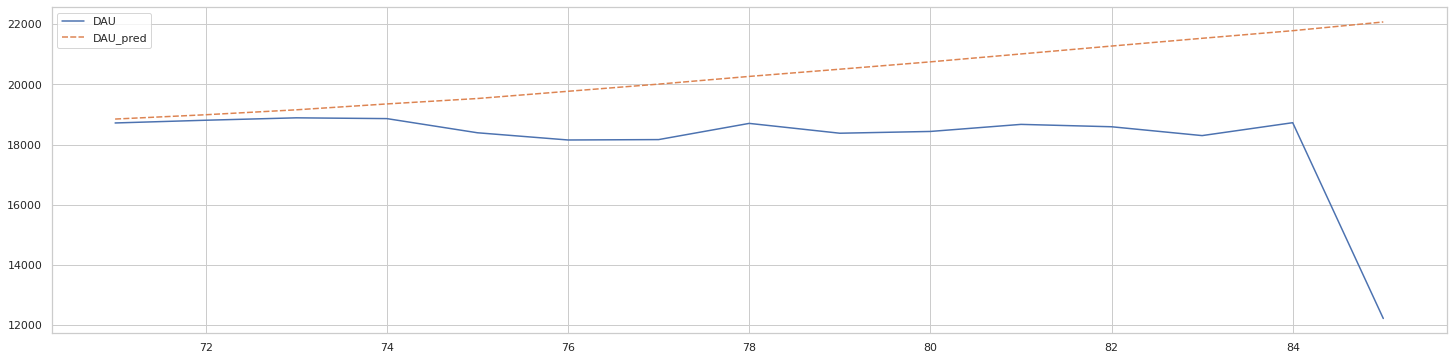

In [133]:
sns.lineplot(df_test.filter(regex=r"day|DAU|DAU_pred"))

<Axes: >

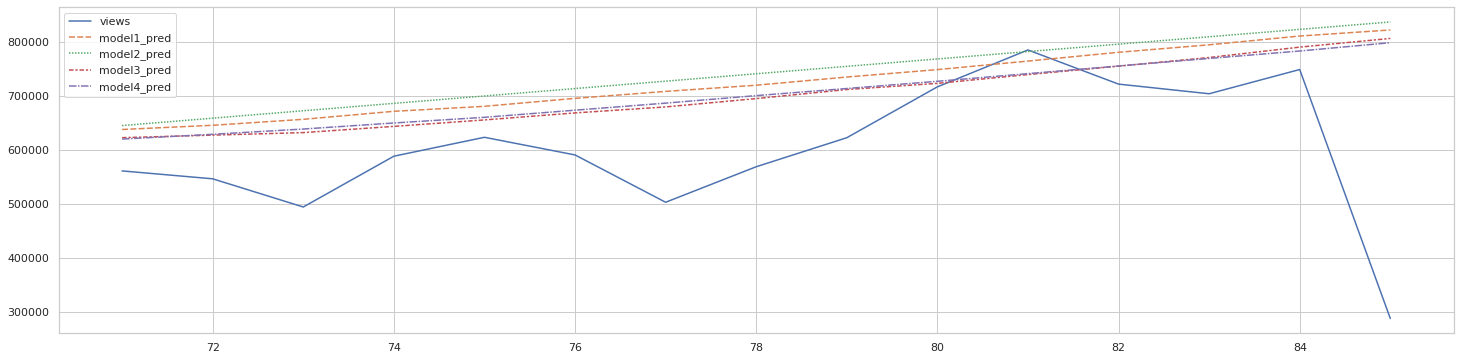

In [136]:
sns.lineplot(df_test.filter(regex=r"day|views|^model"))

---
Все наши модели систематически завышают прогноз. Возможно, учитывая завышение прогноза DAU, это и повлияло, что модели 3,4, не улучшили прогнозирование. 

Следующим шагом может быть перепрогнозирование DAU с помощью логлинейное регрессии и повторная проверка моделей 3,4.

---